# Pytorch MNIST手書き数字の分類 - 畳み込み層ネットワーク -

- 畳み込み層（CNN）で構築したネットワークの実装を行い、MNIST分類を学習し推論します。

# 事前準備

## モジュールインポート

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## GPUとCPUの自動判別

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用デバイス:", device)

使用デバイス: cpu


# Datasetの準備

## MNISTデータセット

In [5]:
#データ前処理 transform を設定
transform = transforms.Compose(
    [transforms.ToTensor(),                      # Tensor変換とshape変換 [H, W, C] -> [C, H, W]
     transforms.Normalize((0.5, ), (0.5, ))])    # 標準化 平均:0.5  標準偏差:0.5


#訓練用(train + validation)のデータセット サイズ:(channel, height, width) = (1,28,28) 60000枚
trainval_dataset = datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)

#訓練用ータセットを train と val にshuffleして分割する
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [40000, 20000])

print("train_dataset size = {}".format(len(train_dataset)))
print("val_dataset size = {}".format(len(val_dataset)))

#テスト(test)用のデータセット サイズ:(channel, height, width) = (1,28,28) 10000枚
test_dataset = datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)

train_dataset size = 40000
val_dataset size = 20000


# Detaloaderの作成

In [6]:
#訓練用 Dataloder
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=64,
                                            shuffle=True)
#検証用 Dataloder
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=64,
                                            shuffle=False)

#テスト用 Dataloder
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                            batch_size=64,
                                            shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

## 動作の確認

imges size =  torch.Size([64, 1, 28, 28])
labels size =  torch.Size([64])


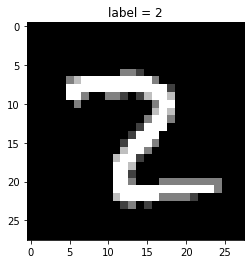

In [8]:
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
imges, labels = next(batch_iterator)  # 1番目の要素を取り出す
print("imges size = ", imges.size())
print("labels size = ", labels.size())

#試しに1枚 plot してみる
plt.imshow(imges[0].numpy().reshape(28,28), cmap='gray')
plt.title("label = {}".format(labels[0].numpy()))
plt.show()

# ネットワークモデルの作成
- 畳み込み層CNNのモデル

In [9]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)              # (Batch,  1, 28, 28) -> (Batch, 32, 26, 26)
        x = F.relu(x)
        x = self.conv2(x)              # (Batch, 32, 26, 26) -> (Batch, 64, 24, 24)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)         # (Batch, 64, 24, 24) -> (Batch, 64, 12, 12)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)        # (Batch, 64, 12, 12) -> (Batch, 9216)
        x = self.fc1(x)                # (Batch, 9216) -> (Batch, 128)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)                # (Batch, 128) -> (Batch, 10)

        return x

In [10]:
#モデル作成
net = Net().to(device)   # GPUを使用する場合のために明示的に .to(device) を指定

In [12]:
#ネットワークのレイヤー確認
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# 損失関数の定義

In [13]:
# nn.CrossEntropyLoss() はソフトマックス関数＋クロスエントロピー誤差
criterion = nn.CrossEntropyLoss()

# 最適化手法の設定

In [14]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 学習・検証の実施

In [15]:
# モデルを学習させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer, device, num_epochs):
    
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for i , (inputs, labels) in tqdm(enumerate(dataloaders_dict[phase])):
                
                # GPUを使用する場合は明示的に指定
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):  # 訓練モードのみ勾配を算出
                    outputs = net(inputs)              # 順伝播
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)   # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


In [16]:
# 学習・検証を実行する
num_epochs = 3
train_model(net, dataloaders_dict, criterion, optimizer, device, num_epochs=num_epochs)





0it [00:00, ?it/s]



1it [00:00,  9.16it/s]

Epoch 1/3
-------------






3it [00:00, 13.95it/s]



5it [00:00, 14.95it/s]



8it [00:00, 17.72it/s]



10it [00:00, 16.52it/s]



12it [00:00, 17.49it/s]



14it [00:00, 18.02it/s]



17it [00:00, 19.16it/s]



19it [00:01, 18.09it/s]



22it [00:01, 19.11it/s]



24it [00:01, 18.68it/s]



27it [00:01, 19.66it/s]



29it [00:01, 18.58it/s]



31it [00:01, 18.42it/s]



33it [00:01, 18.25it/s]



35it [00:01, 18.29it/s]



37it [00:02, 18.04it/s]



39it [00:02, 16.94it/s]



42it [00:02, 18.18it/s]



44it [00:02, 18.55it/s]



47it [00:02, 19.90it/s]



49it [00:02, 19.39it/s]



51it [00:02, 19.16it/s]



53it [00:02, 19.25it/s]



55it [00:03, 18.65it/s]



58it [00:03, 19.73it/s]



60it [00:03, 17.93it/s]



63it [00:03, 18.37it/s]



66it [00:03, 19.49it/s]



69it [00:03, 19.97it/s]



71it [00:03, 19.80it/s]



74it [00:03, 19.89it/s]



76it [00:04, 19.78it/s]



78it [00:04, 19.45it/s]



80it [00:04, 19.01it/s]



82it [00:04, 18.93it/s]



85it [00:04, 19.65it/s]



88it [00:04, 20.16it/s]





val Loss: 2.3056 Acc: 0.0817
Epoch 2/3
-------------






1it [00:00,  4.55it/s]



2it [00:00,  5.54it/s]



3it [00:00,  5.99it/s]



4it [00:00,  6.51it/s]



5it [00:00,  6.85it/s]



6it [00:00,  6.72it/s]



7it [00:01,  7.06it/s]



8it [00:01,  7.11it/s]



9it [00:01,  7.16it/s]



10it [00:01,  7.02it/s]



11it [00:01,  7.03it/s]



12it [00:01,  6.81it/s]



13it [00:01,  7.04it/s]



14it [00:02,  7.26it/s]



15it [00:02,  7.22it/s]



16it [00:02,  7.30it/s]



17it [00:02,  7.38it/s]



18it [00:02,  6.96it/s]



19it [00:02,  7.20it/s]



20it [00:02,  7.41it/s]



21it [00:03,  7.48it/s]



22it [00:03,  7.50it/s]



23it [00:03,  7.68it/s]



24it [00:03,  7.91it/s]



25it [00:03,  8.28it/s]



26it [00:03,  8.04it/s]



27it [00:03,  8.27it/s]



28it [00:03,  8.26it/s]



29it [00:03,  8.37it/s]



30it [00:04,  7.22it/s]



31it [00:04,  6.80it/s]



32it [00:04,  7.23it/s]



33it [00:04,  7.64it/s]



34it [00:04,  7.77it/s]



35it [00:04,  8.10it/s]



36it [00:04,  8.14it/s]



37it [00:05,  8.21it/s]



38it [

208it [00:27,  6.54it/s]



209it [00:28,  6.66it/s]



210it [00:28,  6.75it/s]



211it [00:28,  6.97it/s]



212it [00:28,  7.21it/s]



213it [00:28,  7.15it/s]



214it [00:28,  7.25it/s]



215it [00:28,  7.34it/s]



216it [00:29,  7.45it/s]



217it [00:29,  7.33it/s]



218it [00:29,  7.45it/s]



219it [00:29,  7.42it/s]



220it [00:29,  7.47it/s]



221it [00:29,  7.19it/s]



222it [00:29,  6.94it/s]



223it [00:30,  6.73it/s]



224it [00:30,  6.85it/s]



225it [00:30,  6.34it/s]



226it [00:30,  6.51it/s]



227it [00:30,  6.63it/s]



228it [00:30,  6.53it/s]



229it [00:30,  6.60it/s]



230it [00:31,  6.61it/s]



231it [00:31,  6.78it/s]



232it [00:31,  6.66it/s]



233it [00:31,  6.89it/s]



234it [00:31,  6.93it/s]



235it [00:31,  7.09it/s]



236it [00:31,  6.82it/s]



237it [00:32,  6.85it/s]



238it [00:32,  6.27it/s]



239it [00:32,  5.59it/s]



240it [00:32,  5.95it/s]



241it [00:32,  6.32it/s]



242it [00:32,  6.19it/s]



243it [00:33,  6.32i

412it [01:00,  6.10it/s]



413it [01:00,  6.32it/s]



414it [01:00,  6.34it/s]



415it [01:00,  6.44it/s]



416it [01:00,  6.29it/s]



417it [01:01,  6.32it/s]



418it [01:01,  6.38it/s]



419it [01:01,  6.44it/s]



420it [01:01,  6.47it/s]



421it [01:01,  6.40it/s]



422it [01:01,  6.47it/s]



423it [01:02,  6.62it/s]



424it [01:02,  6.63it/s]



425it [01:02,  6.72it/s]



426it [01:02,  6.63it/s]



427it [01:02,  6.69it/s]



428it [01:02,  6.23it/s]



429it [01:02,  6.22it/s]



430it [01:03,  6.40it/s]



431it [01:03,  6.14it/s]



432it [01:03,  6.26it/s]



433it [01:03,  6.14it/s]



434it [01:03,  6.29it/s]



435it [01:03,  5.89it/s]



436it [01:04,  5.98it/s]



437it [01:04,  6.19it/s]



438it [01:04,  6.27it/s]



439it [01:04,  6.36it/s]



440it [01:04,  6.45it/s]



441it [01:04,  6.46it/s]



442it [01:05,  6.36it/s]



443it [01:05,  5.90it/s]



444it [01:05,  5.98it/s]



445it [01:05,  6.15it/s]



446it [01:05,  6.25it/s]



447it [01:05,  6.40i

616it [01:31,  6.86it/s]



617it [01:32,  6.86it/s]



618it [01:32,  6.36it/s]



619it [01:32,  6.09it/s]



620it [01:32,  6.08it/s]



621it [01:32,  6.31it/s]



622it [01:32,  6.51it/s]



623it [01:33,  6.70it/s]



624it [01:33,  6.59it/s]



625it [01:33,  6.70it/s]




0it [00:00, ?it/s]



2it [00:00, 16.30it/s]

train Loss: 0.2812 Acc: 0.9159






4it [00:00, 16.87it/s]



6it [00:00, 15.71it/s]



8it [00:00, 15.65it/s]



10it [00:00, 15.76it/s]



12it [00:00, 16.21it/s]



14it [00:00, 16.22it/s]



16it [00:00, 16.20it/s]



18it [00:01, 15.95it/s]



20it [00:01, 16.50it/s]



22it [00:01, 17.00it/s]



24it [00:01, 16.01it/s]



26it [00:01, 16.45it/s]



28it [00:01, 16.57it/s]



30it [00:01, 16.91it/s]



32it [00:01, 16.43it/s]



34it [00:02, 16.29it/s]



36it [00:02, 16.22it/s]



38it [00:02, 16.65it/s]



40it [00:02, 17.14it/s]



42it [00:02, 16.69it/s]



44it [00:02, 16.88it/s]



46it [00:02, 16.66it/s]



48it [00:02, 16.97it/s]



50it [00:03, 16.85it/s]



52it [00:03, 17.24it/s]



54it [00:03, 17.04it/s]



56it [00:03, 17.02it/s]



58it [00:03, 17.19it/s]



60it [00:03, 16.50it/s]



62it [00:03, 16.77it/s]



64it [00:03, 16.50it/s]



66it [00:03, 16.73it/s]



68it [00:04, 17.18it/s]



70it [00:04, 17.64it/s]



72it [00:04, 17.37it/s]



74it [00:04, 17.54it/s]



76it [00:04, 17.79it/s]





val Loss: 0.0737 Acc: 0.9774
Epoch 3/3
-------------






2it [00:00,  7.87it/s]



3it [00:00,  8.05it/s]



4it [00:00,  7.68it/s]



5it [00:00,  7.34it/s]



6it [00:00,  7.40it/s]



7it [00:00,  7.70it/s]



8it [00:01,  7.73it/s]



9it [00:01,  7.89it/s]



10it [00:01,  7.77it/s]



11it [00:01,  8.10it/s]



12it [00:01,  8.08it/s]



13it [00:01,  7.64it/s]



14it [00:01,  7.66it/s]



15it [00:01,  7.77it/s]



16it [00:02,  7.95it/s]



17it [00:02,  8.01it/s]



18it [00:02,  8.17it/s]



19it [00:02,  8.17it/s]



20it [00:02,  8.25it/s]



21it [00:02,  8.05it/s]



22it [00:02,  8.16it/s]



23it [00:02,  8.12it/s]



24it [00:03,  8.27it/s]



25it [00:03,  8.35it/s]



26it [00:03,  8.17it/s]



27it [00:03,  8.33it/s]



28it [00:03,  8.40it/s]



29it [00:03,  8.16it/s]



30it [00:03,  8.26it/s]



31it [00:03,  8.35it/s]



32it [00:03,  8.26it/s]



33it [00:04,  8.27it/s]



34it [00:04,  8.19it/s]



35it [00:04,  8.28it/s]



36it [00:04,  8.34it/s]



37it [00:04,  8.30it/s]



38it [00:04,  8.13it/s]



39it 

209it [00:26,  7.63it/s]



210it [00:26,  7.81it/s]



211it [00:26,  7.69it/s]



212it [00:27,  7.75it/s]



213it [00:27,  7.65it/s]



214it [00:27,  7.65it/s]



215it [00:27,  7.45it/s]



216it [00:27,  7.45it/s]



217it [00:27,  7.23it/s]



218it [00:27,  7.01it/s]



219it [00:28,  7.00it/s]



220it [00:28,  7.18it/s]



221it [00:28,  6.97it/s]



222it [00:28,  7.11it/s]



223it [00:28,  7.39it/s]



224it [00:28,  7.57it/s]



225it [00:28,  7.60it/s]



226it [00:28,  7.87it/s]



227it [00:29,  7.88it/s]



228it [00:29,  7.98it/s]



229it [00:29,  7.68it/s]



230it [00:29,  7.63it/s]



231it [00:29,  7.66it/s]



232it [00:29,  7.69it/s]



233it [00:29,  7.63it/s]



234it [00:30,  7.76it/s]



235it [00:30,  7.78it/s]



236it [00:30,  7.89it/s]



237it [00:30,  7.36it/s]



238it [00:30,  7.51it/s]



239it [00:30,  7.44it/s]



240it [00:30,  7.54it/s]



241it [00:30,  7.03it/s]



242it [00:31,  7.11it/s]



243it [00:31,  7.17it/s]



244it [00:31,  7.39i

413it [00:54,  6.90it/s]



414it [00:54,  6.71it/s]



415it [00:54,  6.98it/s]



416it [00:54,  7.10it/s]



417it [00:54,  7.34it/s]



418it [00:54,  7.10it/s]



419it [00:55,  6.68it/s]



420it [00:55,  6.31it/s]



421it [00:55,  5.80it/s]



422it [00:55,  5.86it/s]



423it [00:55,  6.02it/s]



424it [00:55,  6.35it/s]



425it [00:56,  6.78it/s]



426it [00:56,  6.93it/s]



427it [00:56,  7.17it/s]



428it [00:56,  7.06it/s]



429it [00:56,  7.17it/s]



430it [00:56,  7.30it/s]



431it [00:56,  7.47it/s]



432it [00:57,  7.53it/s]



433it [00:57,  7.61it/s]



434it [00:57,  7.61it/s]



435it [00:57,  7.57it/s]



436it [00:57,  7.58it/s]



437it [00:57,  7.76it/s]



438it [00:57,  7.62it/s]



439it [00:57,  7.44it/s]



440it [00:58,  7.41it/s]



441it [00:58,  7.51it/s]



442it [00:58,  7.49it/s]



443it [00:58,  7.49it/s]



444it [00:58,  7.54it/s]



445it [00:58,  7.64it/s]



446it [00:58,  7.73it/s]



447it [00:58,  7.58it/s]



448it [00:59,  7.71i

617it [01:24,  6.92it/s]



618it [01:24,  7.00it/s]



619it [01:24,  7.20it/s]



620it [01:25,  7.17it/s]



621it [01:25,  7.24it/s]



622it [01:25,  7.19it/s]



623it [01:25,  7.29it/s]



624it [01:25,  7.46it/s]



625it [01:25,  7.28it/s]




0it [00:00, ?it/s]



2it [00:00, 18.92it/s]

train Loss: 0.1115 Acc: 0.9668






4it [00:00, 18.92it/s]



6it [00:00, 17.84it/s]



8it [00:00, 18.06it/s]



10it [00:00, 16.63it/s]



12it [00:00, 16.60it/s]



14it [00:00, 16.73it/s]



16it [00:00, 17.27it/s]



18it [00:01, 17.88it/s]



20it [00:01, 16.97it/s]



22it [00:01, 17.31it/s]



24it [00:01, 17.61it/s]



26it [00:01, 17.87it/s]



28it [00:01, 17.81it/s]



30it [00:01, 18.08it/s]



32it [00:01, 17.83it/s]



34it [00:01, 16.32it/s]



36it [00:02, 16.24it/s]



38it [00:02, 15.50it/s]



40it [00:02, 14.49it/s]



42it [00:02, 14.10it/s]



44it [00:02, 13.58it/s]



46it [00:02, 14.04it/s]



48it [00:02, 14.75it/s]



50it [00:03, 15.58it/s]



52it [00:03, 14.71it/s]



54it [00:03, 15.02it/s]



56it [00:03, 15.52it/s]



58it [00:03, 15.30it/s]



60it [00:03, 15.47it/s]



62it [00:03, 14.71it/s]



64it [00:04, 15.17it/s]



66it [00:04, 15.42it/s]



68it [00:04, 15.13it/s]



70it [00:04, 15.68it/s]



72it [00:04, 15.99it/s]



74it [00:04, 15.58it/s]



76it [00:04, 16.04it/s]





val Loss: 0.0498 Acc: 0.9852


# テストデータに対する予測

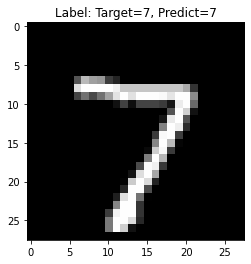

In [21]:
batch_iterator = iter(dataloaders_dict["test"])  # イテレータに変換
imges, labels = next(batch_iterator)  # 1番目の要素を取り出す

net.eval() #推論モード
with torch.set_grad_enabled(False):   # 推論モードでは勾配を算出しない
    outputs = net(imges)               # 順伝播
    _, preds = torch.max(outputs, 1)  # ラベルを予測
    
#テストデータの予測結果を描画
plt.imshow(imges[0].numpy().reshape(28,28), cmap='gray')
plt.title("Label: Target={}, Predict={}".format(labels[0], preds[0].numpy()))
plt.show()

以上